## Overview
### This Notebook will go over the process of combining manually annotated behavioral data with computer-generated behavioral data to detect which generated clusters correspond to particular behaviors.

## Setting up paths, importing dependencies and data

### Set up paths that will be necessary to load data

In [1]:
PROJECT_PATH = "/Users/lukefoster/Documents/CompEtho/BM_GPU/"
DATA_PATH = f"{PROJECT_PATH}/results/ant_antennae/"
CONFIG_PATH = f"{PROJECT_PATH}/config_ant_antennae.yaml"

### Import necessary Python libraries

In [2]:
import sys
import numpy as np
import random, matplotlib
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append(PROJECT_PATH)
from utils.data import Dataset
from utils import cluster_comparison

### Load cluster data and convert to dictionary to allow for easier manipulation

In [3]:
RESULT_PATH = "/Users/lukefoster/Documents/CompEtho/BM_GPU/results/ant_antennae"
TARGET_DIR_PATH = "/Users/lukefoster/Documents/CompEtho/Cluster_Comparison_Pipeline"

cluster_comparison.create_group_folders(RESULT_PATH, TARGET_DIR_PATH)

CLUSTER_PATH = f"{TARGET_DIR_PATH}/cluster"
cluster_dict = cluster_comparison.create_normalized_cluster_csv(CLUSTER_PATH, TARGET_DIR_PATH)

Unable to create Target directory. Directory already exists.
Unable to create cluster directory. Directory already exists.
07YTminfd_antmovie200928211544 has 0 good clusters
newant_antmovie200924212211 has 0 good clusters
12RWminfd_antmovie200927224447 has 0 good clusters
10BYmidfd_antmovie200928222401 has 0 good clusters
11RBminfd_antmovie200927222415 has 0 good clusters
00AAmidfr_antmovie200926192629 has 0 good clusters
01SSmidfr_antmovie201010190036 has 0 good clusters
02BBmidfd_antmovie200926202619 has 0 good clusters


## Setting up Analysis Dataframe

### Combine generated clusters with manually annotated data into single dataframe by video frame

In [5]:
CSV_PATH = "/Users/lukefoster/Desktop"
videos = ["02WGmidfd_antmovie201010194713","06dDminfd_antmovie200926213750"]
dfs = []

for video in videos:
    df = pd.read_csv(f"{CSV_PATH}/{video}.csv")
    gen = cluster_dict[video]
    syllable = []
    for frame in range(len(df)):
        try:
            syllable.append(int(gen[frame]))
        except:
            syllable.append(-1)
    df['syllable'] = syllable
    dfs.append(df)
    
df = pd.concat(dfs)
df = df.reset_index(drop=True)

df

,manual_anno,syllable
0,walk_slow_atn_ground,4
1,walk_slow_atn_ground,4
2,walk_slow_atn_ground,4
3,walk_slow_atn_ground,4
4,walk_slow_atn_ground,4
...,...,...
29249,reached_food,-1
29250,reached_food,-1
29251,reached_food,-1
29252,reached_food,-1


### Generate list of all behaviors recognized by manual annotations

In [13]:
behaviors = []
for frame in range(len(df)):
    if df['manual_anno'][frame] not in behaviors:
        behaviors.append(df['manual_anno'][frame])
    
behaviors

['walk_slow_atn_ground',
 'st_atn_ground',
 'st_limb_mvng',
 '-1',
 'st_atn_mvng',
 'walk_slow_atn_ground_2',
 'st_atn_wall',
 'st_climb_wall',
 '-2',
 'walk_on_wall',
 'walk_mid_atn_ground',
 'walk_slow',
 'walk_slow_ch_dir_r',
 'st_ch_dir_l',
 'walk_slow_atn_ground_3',
 'walk_mid_atn_ground_2',
 'walk_slow_atn_x',
 'walk_slow_ch_dir_l',
 'st_ch_dir_r',
 'st_atn_air',
 'walk_back',
 'grooming_leg',
 'st_frozen',
 'grooming_leg_l',
 'walk_slow_z_atn_x',
 'grooming_leg_r',
 'st_atn_x',
 'reached_food',
 'walk_slow_ch_dir',
 'st_ch_dir',
 'st_atn_ground_ch_dir',
 'walk_crab']

### Define function that will create a dataframe for a specific behavior that contains the cluster frequency per occasion

In [36]:
def occ_df(behavior):
    # calculate all clusters detected in video file
    vid_clusters = []
    for frame in range(len(df)):
        if df['syllable'][frame] not in vid_clusters:
            vid_clusters.append(df['syllable'][frame])
    vid_clusters.sort()

    # create an empty list (this will be a list or lists that will be converted into an array later)
    array = []
    seek = behavior
    occurance = 0
    frame = 0

    # loop through all frames
    while frame < len(df):
        # if the current frame is the behavior we're looking for
        if df['manual_anno'][frame] == seek:
            occurance += 1
            # create empty list that will store syllable info for this occurance
            c = []
            # continue until we reach a frame of some other behavior
            while df['manual_anno'][frame] == seek:
                # add frame's syllable info to 'c' list and increment frame
                c.append(df['syllable'][frame])
                frame += 1
            # create empty dictionary that will be filled with count data for each syllable
            counts = {}
            for syllable in c:
                if syllable not in counts.keys():
                    counts[syllable] = c.count(syllable)
            # create empty row that will store data in tuples for this occurance
            row = [0] * (len(vid_clusters)+1)
            # loop through counts dictionary and add each syllable and count to assigned spot in 'row' list
            tot = 0
            for item in counts.items():
                index = vid_clusters.index(item[0])
                row[index] = item[1]
                tot += item[1]
            # add sum of frame counts to last column in 'row' list
            row[-1] = tot
            # add 'row' list to overall 'array' list
            array.append(row)
        else:
            frame += 1

    length = max(map(len, array))
    depth = len(array)

    if length > 1 and depth > 1:
        array = np.array([xi+[0]*(length-len(xi)) for xi in array])

    # convert array into DataFrame
    df_new = pd.DataFrame(array)
    # rename df columns
    for column in range(df_new.shape[1]-1):
        df_new = df_new.rename({column: f'cluster {vid_clusters[column]}'}, axis='columns')
    df_new = df_new.rename({df_new.shape[1]-1: 'total'}, axis='columns')
    #rename df rows
    for row in range(df_new.shape[0]):
        df_new = df_new.rename({row: f'occ {row+1}'})
    
    # create row with sums of clusters across occasions
    df_new.loc['total']= df_new.sum()
    
    return df_new

In [37]:
occ_df("walk_slow_atn_ground")

,cluster -1,cluster 3,cluster 4,cluster 5,cluster 30,cluster 31,cluster 33,total
occ 1,0,0,27,0,0,0,0,27
occ 2,4,30,29,0,0,16,0,79
occ 3,45,0,0,0,0,0,0,45
occ 4,10,0,0,0,0,0,0,10
occ 5,53,0,0,0,0,0,0,53
...,...,...,...,...,...,...,...,...
occ 158,87,0,0,0,0,0,0,87
occ 159,17,0,0,0,0,0,0,17
occ 160,15,0,0,0,0,0,0,15
occ 161,39,0,0,0,0,0,0,39


### Save which clusters are present in the video files being looked at

In [38]:
vid_clusters = []

for frame in range(len(df)):
    if df['syllable'][frame] not in vid_clusters:
        vid_clusters.append(df['syllable'][frame])
        
vid_clusters.sort()
vid_clusters

[-1, 3, 4, 5, 30, 31, 33]

### Show behavior dataframes for each behavior

In [39]:
for behavior in behaviors:
    if behavior != "reached_food":
        print(behavior)
        print(f"{occ_df(behavior)}\n")

walk_slow_atn_ground
         cluster -1  cluster 3  cluster 4  cluster 5  cluster 30  cluster 31  \
occ 1             0          0         27          0           0           0   
occ 2             4         30         29          0           0          16   
occ 3            45          0          0          0           0           0   
occ 4            10          0          0          0           0           0   
occ 5            53          0          0          0           0           0   
...             ...        ...        ...        ...         ...         ...   
occ 158          87          0          0          0           0           0   
occ 159          17          0          0          0           0           0   
occ 160          15          0          0          0           0           0   
occ 161          39          0          0          0           0           0   
total         10588        159         68         13           0          96   

         cluster 3

        cluster -1  cluster 3  cluster 4  cluster 5  cluster 30  cluster 31  \
occ 1            9          0          0          0           0           0   
occ 2            8          0          0          0           0           0   
occ 3           11          0          0          0           0           0   
occ 4            8          0          0          0           0           0   
occ 5            7          0          0          0           0           0   
occ 6            0          6          0          0           0           2   
occ 7            7          0          0          0           0           0   
occ 8           14          0          0          0           0           0   
occ 9            6          0          0          0           0           0   
occ 10           0          0          0          5           0           7   
occ 11           0          0          5          0           0           4   
occ 12          10          0          0          0 

        cluster -1  cluster 3  cluster 4  cluster 5  cluster 30  cluster 31  \
occ 1          454          0          0          0           0           0   
occ 2           35          0          0          0           0           0   
occ 3            5          0          0          0           0           0   
occ 4            6          0          0          0           0           0   
occ 5           10          0          0          0           0           0   
occ 6            1          0          0          0           0           0   
occ 7            8          0          0          0           0           0   
occ 8            1          0          0          0           0           0   
occ 9            3          0          0          0           0           0   
occ 10          15          0          0          0           0           0   
occ 11           3          0          0          0           0           0   
occ 12           1          0          0          0 

        cluster -1  cluster 3  cluster 4  cluster 5  cluster 30  cluster 31  \
occ 1           21          0          0          0           0           0   
occ 2           68          0          0          0           0           0   
occ 3           60          0          0          0           0           0   
occ 4           71         25          8         11           1          13   
occ 5           20          0          0          0           0           0   
occ 6           62          0          0          0           0           0   
occ 7           11          0          0          0           0           0   
occ 8           13          0          0          0           0           0   
occ 9            5          0          0          0           0           0   
occ 10           3          0          1          0           0           9   
occ 11          63          0          0          0           0           0   
occ 12          63          0          0          0 

       cluster -1  cluster 3  cluster 4  cluster 5  cluster 30  cluster 31  \
occ 1           2          0          0          0           0           0   
occ 2           4          0          0          0           0           0   
total           6          0          0          0           0           0   

       cluster 33  total  
occ 1           0      2  
occ 2           0      4  
total           0      6  

grooming_leg
       cluster -1  cluster 3  cluster 4  cluster 5  cluster 30  cluster 31  \
occ 1           9          0          0          0           0           0   
total           9          0          0          0           0           0   

       cluster 33  total  
occ 1           0      9  
total           0      9  

st_frozen
        cluster -1  cluster 3  cluster 4  cluster 5  cluster 30  cluster 31  \
occ 1            5          0          0          0           0           0   
occ 2            4          0          0          0           0           0   
o

       cluster -1  cluster 3  cluster 4  cluster 5  cluster 30  cluster 31  \
occ 1           8          0          0          0           0           0   
total           8          0          0          0           0           0   

       cluster 33  total  
occ 1           0      8  
total           0      8  



## Graphing behavior data (for example behavior walk_slow_atn_ground_2)

### Get rid of occasions with only 'cluster -1' entries

In [52]:
data = occ_df("walk_slow_atn_ground_2")
drops = []
for i in range(len(data)-1):
    if data['cluster -1'][i] == data['total'][i]:
        drops.append(f'occ {i+1}')
data = data.drop(drops, axis=0)
data

,cluster -1,cluster 3,cluster 4,cluster 5,cluster 30,cluster 31,cluster 33,total
occ 2,78,10,28,77,0,37,3,233
occ 3,0,0,0,0,0,17,6,23
occ 6,0,46,1,0,0,5,0,52
occ 7,0,14,0,0,0,0,0,14
occ 8,0,0,0,0,0,15,0,15
occ 9,0,10,0,0,0,7,0,17
occ 10,10,12,9,30,0,10,0,71
occ 16,32,12,0,6,0,0,0,50
occ 17,36,1,0,0,0,11,0,48
occ 20,62,84,0,14,0,24,0,184


### Remove 'cluster -1' column and recalculate total

In [53]:
for i in range(len(data)-1):
    data['total'][i] -= data['cluster -1'][i]

data = data.drop(['cluster -1'], axis=1)


data

,cluster 3,cluster 4,cluster 5,cluster 30,cluster 31,cluster 33,total
occ 2,10,28,77,0,37,3,155
occ 3,0,0,0,0,17,6,23
occ 6,46,1,0,0,5,0,52
occ 7,14,0,0,0,0,0,14
occ 8,0,0,0,0,15,0,15
occ 9,10,0,0,0,7,0,17
occ 10,12,9,30,0,10,0,61
occ 16,12,0,6,0,0,0,18
occ 17,1,0,0,0,11,0,12
occ 20,84,0,14,0,24,0,122


### Normalize data; convert entries to frequency

In [55]:
for i in range(len(data)):
    for cluster in vid_clusters:
        if cluster != -1:
            data[f'cluster {cluster}'][i] = (data[f'cluster {cluster}'][i] / data['total'][i]) * 100

data

,cluster 3,cluster 4,cluster 5,cluster 30,cluster 31,cluster 33,total
occ 2,6,18,49,0,23,1,155
occ 3,0,0,0,0,73,26,23
occ 6,88,1,0,0,9,0,52
occ 7,100,0,0,0,0,0,14
occ 8,0,0,0,0,100,0,15
occ 9,58,0,0,0,41,0,17
occ 10,19,14,49,0,16,0,61
occ 16,66,0,33,0,0,0,18
occ 17,8,0,0,0,91,0,12
occ 20,68,0,11,0,19,0,122


### Get rid of 'total' column and row

In [56]:
data = data.drop(['total'], axis=1)
data = data.drop(['total'], axis=0)
data

,cluster 3,cluster 4,cluster 5,cluster 30,cluster 31,cluster 33
occ 2,6,18,49,0,23,1
occ 3,0,0,0,0,73,26
occ 6,88,1,0,0,9,0
occ 7,100,0,0,0,0,0
occ 8,0,0,0,0,100,0
occ 9,58,0,0,0,41,0
occ 10,19,14,49,0,16,0
occ 16,66,0,33,0,0,0
occ 17,8,0,0,0,91,0
occ 20,68,0,11,0,19,0


### Behavior occasion graph

<Figure size 432x288 with 0 Axes>

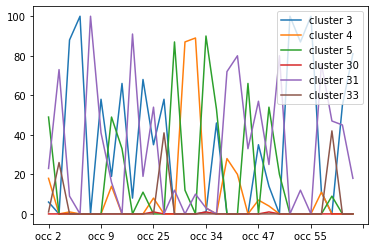

In [57]:
plt.figure()
data.plot()
plt.show()

## Graphing behavior data (for all behaviors)

### Define function that formats dataframe as necessary (gets rid of occasions with bad data, normalizes data, gets rid of unnecessary columns/rows) and plots behavior occasion graph

In [58]:
def plot_freq(behavior):
    data = occ_df(behavior)
    drops = []
    for i in range(len(data)):
        if data['cluster -1'][i] == data['total'][i]:
            drops.append(f'occ {i+1}')
    data = data.drop(drops, axis=0)
    for i in range(len(data)-1):
        data['total'][i] -= data['cluster -1'][i]
    data = data.drop(['cluster -1'], axis=1)
    
    for i in range(len(data)):
        for cluster in vid_clusters:
            if cluster != -1:
                data[f'cluster {cluster}'][i] = (data[f'cluster {cluster}'][i] / data['total'][i]) * 100
    data = data.drop(['total'], axis=1)
    data = data.drop(['total'], axis=0)
    plt.figure()
    data.plot()
    plt.title(behavior)
    plt.show()

### Run plot_freq function for all behaviors

<Figure size 432x288 with 0 Axes>

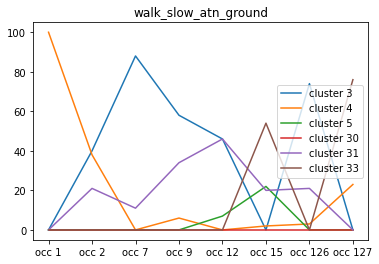

<Figure size 432x288 with 0 Axes>

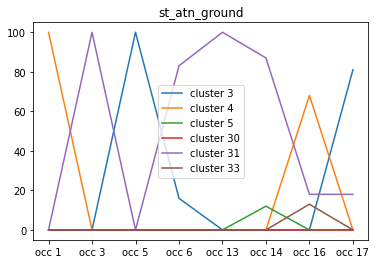

<Figure size 432x288 with 0 Axes>

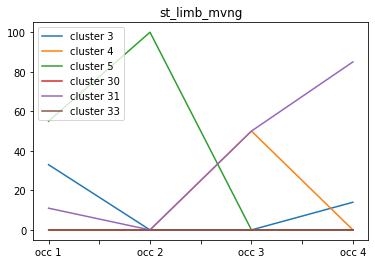

-1: ERROR


<Figure size 432x288 with 0 Axes>

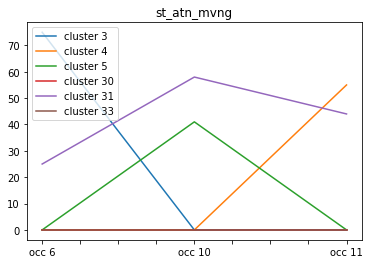

<Figure size 432x288 with 0 Axes>

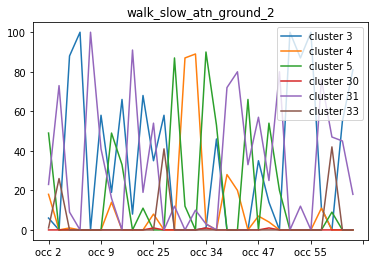

<Figure size 432x288 with 0 Axes>

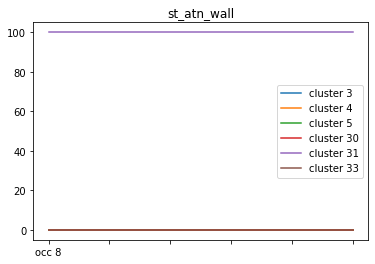

st_climb_wall: ERROR
-2: ERROR
walk_on_wall: ERROR


<Figure size 432x288 with 0 Axes>

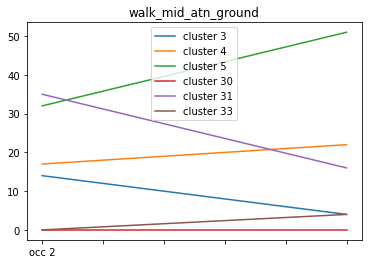

walk_slow: ERROR


<Figure size 432x288 with 0 Axes>

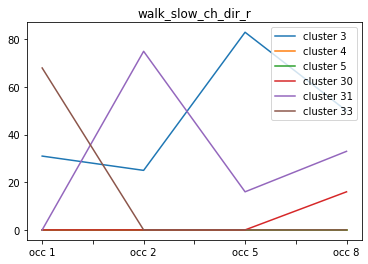

<Figure size 432x288 with 0 Axes>

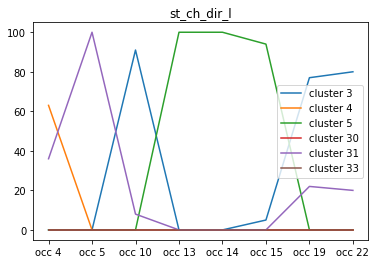

<Figure size 432x288 with 0 Axes>

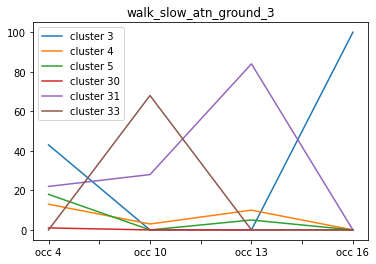

<Figure size 432x288 with 0 Axes>

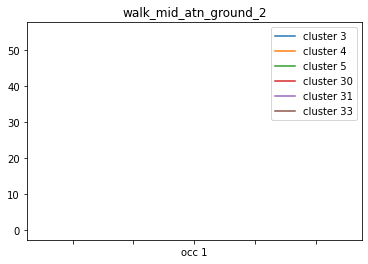

walk_slow_atn_x: ERROR


<Figure size 432x288 with 0 Axes>

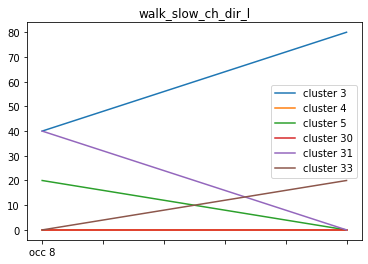

<Figure size 432x288 with 0 Axes>

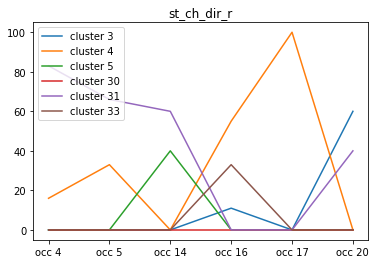

<Figure size 432x288 with 0 Axes>

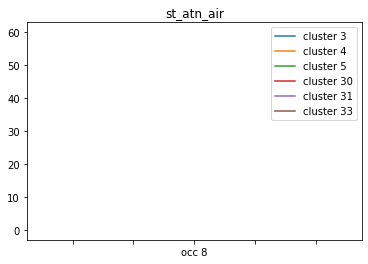

walk_back: ERROR
grooming_leg: ERROR


<Figure size 432x288 with 0 Axes>

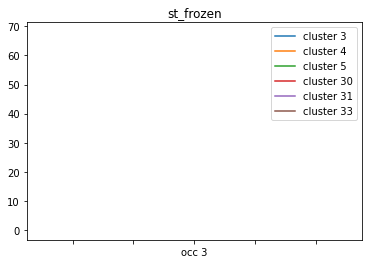

<Figure size 432x288 with 0 Axes>

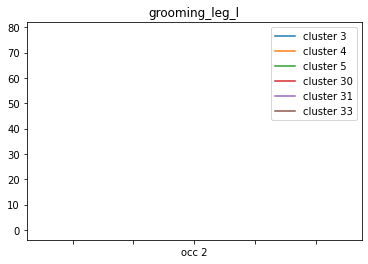

<Figure size 432x288 with 0 Axes>

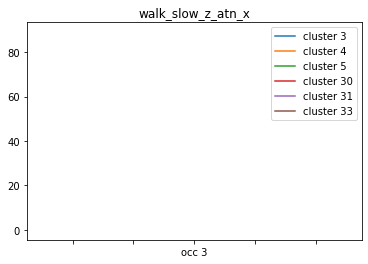

grooming_leg_r: ERROR
st_atn_x: ERROR
reached_food: ERROR


<Figure size 432x288 with 0 Axes>

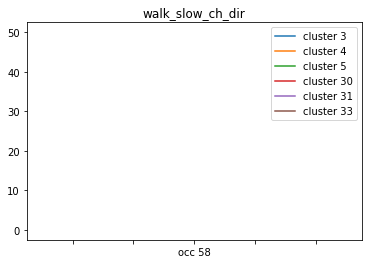

st_ch_dir: ERROR
st_atn_ground_ch_dir: ERROR
walk_crab: ERROR


In [59]:
for behavior in behaviors:
    try:
        plot_freq(behavior)
    except:
        print(f"{behavior}: ERROR")

In [8]:
cluster_dict["02WGmidfd_antmovie201010194713"]

{0: 4.0,
 1: 4.0,
 2: 4.0,
 3: 4.0,
 4: 4.0,
 5: 4.0,
 6: 4.0,
 7: 4.0,
 8: 4.0,
 9: 4.0,
 10: 4.0,
 11: 4.0,
 12: 4.0,
 13: 4.0,
 14: 4.0,
 15: 4.0,
 16: 4.0,
 17: 4.0,
 18: 4.0,
 19: 4.0,
 20: 4.0,
 21: 4.0,
 22: 4.0,
 23: 4.0,
 24: 4.0,
 25: 4.0,
 26: 4.0,
 27: 4.0,
 28: 4.0,
 29: 4.0,
 30: 4.0,
 31: 4.0,
 32: 4.0,
 33: 4.0,
 34: 4.0,
 35: 4.0,
 36: 4.0,
 37: 4.0,
 38: 4.0,
 39: 4.0,
 40: 4.0,
 41: 4.0,
 42: 4.0,
 43: 4.0,
 44: 4.0,
 45: 4.0,
 46: 4.0,
 47: 4.0,
 48: 4.0,
 49: 4.0,
 50: 4.0,
 51: 4.0,
 52: 4.0,
 53: 4.0,
 54: 4.0,
 55: 4.0,
 56: 4.0,
 57: 4.0,
 58: 4.0,
 59: 4.0,
 60: 4.0,
 61: 4.0,
 62: 4.0,
 63: 4.0,
 64: 4.0,
 65: 4.0,
 66: 4.0,
 67: 4.0,
 68: 4.0,
 69: 4.0,
 70: 3.0,
 71: 3.0,
 72: 3.0,
 73: 3.0,
 74: 3.0,
 75: 3.0,
 76: 3.0,
 77: 3.0,
 78: 3.0,
 79: 3.0,
 80: 3.0,
 81: 3.0,
 82: 3.0,
 83: 3.0,
 84: 3.0,
 85: 3.0,
 86: 3.0,
 87: 3.0,
 88: 3.0,
 89: 31.0,
 90: 31.0,
 91: 31.0,
 92: 31.0,
 93: 31.0,
 94: 31.0,
 95: 31.0,
 96: 31.0,
 97: 31.0,
 98: 31.0,
 99: 31.0,

In [14]:
syllables = []

for key,value in cluster_dict["02WGmidfd_antmovie201010194713"].items():
    

4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
3.0
3.0
3.0
3.0
31.0
31.0
31.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
5.0
5.0
31.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
31.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
31.0
31.0
31.0
31.0
5.0
31.0
31.0
31.0
5.0
5.0
5.0
31.0
31.0
5.0
31.0
31.0
5.0
31.0
31.0
5.0
31.0
31.0
31.0
31.0
31.0
4.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
4.0
4.0
4.0
4.0
4.0
4.0
31.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
3.0
3.0
3.0
3.0
3.0
3.0
4.0
4.0
4.0
4.0
4.0
4.0
31.0
31.0
31.0
4.0
4.0
33.0
33.0
33.0
4.0
3.0
3.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
31.0
31.0
5.0
5.0
5.0
5.0
5.0
5.0

3.0
3.0
3.0
3.0
3.0
3.0
31.0
3.0
31.0
31.0
31.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
31.0
3.0
31.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
31.0
3.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
3.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
3.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
4.0
4.0
4.0
4.0
4.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
5.0
5.0
31.0
31.0
31.0
31.0
33.0
33.0
33.0
33.0
33.0
33.0
33.0
33.0
33.0
31.0
31.0
5.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
5.0
5.0
5.0
31.0
31.0
31.0
31.0
31.0
5.0
31.0
31.0
31.0
31.0
31.0
5.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
4.0
4.0
4.0
4.0
4.0
31.0
31.0
31.0
31.0
31.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
3.0
3.0
3.0
3.0
3.0
3.